# Data - How Institutions of Higher Education Can Mine The Key Ingredient of  A Successful Analytics Program

The development of data analytics programs that foster robust decision support systems have become a key component of strategic initiatives for institutions of higher-education. However, college and university leadership teams remain unsure of how to effectively incorporate analytics into the institution's operations.

The object of this project is to explore the power of a predictive system based on the notion that at the end of each semester we can diagnose the chances of a student graduating in 4 years based on all available information up to that point. 

One main objective is to identify an information saturation point upon which actionable intervention is implemented. The hypothesis is that there exists a local maxima saturation point which provides the most appropriate intervention point.

# Tools

In [1]:
# General
from __future__ import print_function, division
import sys

# Database
import cx_Oracle
from sqlalchemy import create_engine
from getpass import getpass

# Tools
import pandas as pd
import seaborn as sns
import random
import string
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
import time
#import pandas_profiling

pd.options.display.max_columns = None

# Analytics
#import pymc3 as pm
from scipy.stats import beta

#IMBALANCED DATA
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#SciKitLearn Models
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier #(wait for scikit release 18.0)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#XgBoost Model ###################################################################################
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
##################################################################################################

#MODEL SELECTION, #EVALUATION METRICS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Academic Data: Performance & Demographics

#### Grades Data
First we obtain the students grades along with a few variables. The goal is to aggregate the grade records to a semester summary.

In [2]:
username = input('Enter username: ')

password = getpass(prompt='Enter password: ')

Enter username: japitz
Enter password: ········


In [3]:
service_name = 'iraarch'
host = 'ira-oradb01.its.csulb.edu'
port = '1521'
grades_query = 'grd.sql'
dem_query = 'dae.sql'

def db_query(username, password, service_name, host, port, query):

    dsn = cx_Oracle.makedsn(host, port, service_name=service_name)

    cstr = 'oracle://{user}:{password}@{dsn}'.format(
        user=username,
        password=password,
        dsn=dsn
    )

    engine =  create_engine(
        cstr,
        convert_unicode=False,
        pool_recycle=10,
        pool_size=50,
    )

    with open(query, 'r') as f:
        data=f.read()#.replace('\n', '')
        
    return (data, engine)

In [4]:
grades, engine = db_query(username, password, service_name, host, port, grades_query)
grd = pd.read_sql(grades, engine)

demo, engine = db_query(username, password, service_name, host, port, dem_query)
dem = pd.read_sql(demo, engine)


print(grd.shape)
print(dem.shape)

(1049063, 39)
(15802, 24)


In [5]:
grd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049063 entries, 0 to 1049062
Data columns (total 39 columns):
cohort                     1049063 non-null object
emplid                     1049063 non-null object
term_code                  1049063 non-null object
class_term                 1049063 non-null object
session_code               1049063 non-null object
eot_acad_career            1049063 non-null object
eot_program_cd             1049063 non-null object
eot_program                1049063 non-null object
eot_college_cd             1048830 non-null object
eot_college                1048830 non-null object
eot_department_cd          1048830 non-null object
eot_department             1048830 non-null object
eot_acad_plan_cd           1049063 non-null object
eot_acad_plan              1049063 non-null object
class_college_code         1048668 non-null object
class_college              1048668 non-null object
class_dept_code            1048668 non-null object
class_dept          

In [6]:
dem.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15802 entries, 0 to 15801
Data columns (total 24 columns):
emplid                   15802 non-null object
dem_cohort               15802 non-null object
dem_diff_indx            11480 non-null float64
dae_emplid               15802 non-null object
gender                   15802 non-null object
ethnicity                15802 non-null object
first_generation         15802 non-null object
dep_family_size          15802 non-null object
minority                 15802 non-null object
applicant_family_size    15802 non-null object
applicant_income         15802 non-null object
pelltot_emplid           8975 non-null object
pell_eligibility         8975 non-null object
esa_emplid               15801 non-null object
act_comp                 5396 non-null float64
act_read                 5397 non-null float64
act_math                 5398 non-null float64
act_eng                  5394 non-null float64
act_sci                  5397 non-null float64

In [7]:
#Change 'UNKNOWN' to more unique string to avoid having columns with same name after one-hot-encode

dem['first_generation'] = dem['first_generation'].apply(lambda x: 'First Generation Unknown' if x == 'UNKNOWN' else x)
dem['ethnicity'] = dem['ethnicity'].apply(lambda x: 'ETHNICITY UNKNOWN' if x == 'UNKNOWN' else x)

##### Create Training and Test/Validation Sets of Students at this stage to avoid leakeage 

In [8]:
students = pd.DataFrame(grd['emplid'].unique(), columns=['emplid'])

print('there are {} students'.format(students.shape[0]))

there are 26779 students


##### Create the Grades Trainning and Validation Student Set

In [9]:
students_train, students_dev = train_test_split(students, test_size=0.10, random_state=42)

students_train = pd.DataFrame(students_train)

students_dev = pd.DataFrame(students_dev)

In [10]:
students_train.columns = ['EMPLID']
students_dev.columns = ['EMPLID']

In [11]:
grd[grd['emplid']=='011155428'].sort_values(by=['term_code'])

,cohort,emplid,term_code,class_term,session_code,eot_acad_career,eot_program_cd,eot_program,eot_college_cd,eot_college,eot_department_cd,eot_department,eot_acad_plan_cd,eot_acad_plan,class_college_code,class_college,class_dept_code,class_dept,class_prefix,class_prefix_longdesc,class_catalog_nbr,class_section,class_descr,bcmp,bcmp_units_taken,online_course,units_taken,grading_basis,official_grade,earned_credit,units_attempted,grade_points,status_cd,ge_flag,division,gpa_flag,class_instruction_mode,class_instructor_emplid,home_zip_cd
618220,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,WGSS,Women's Gender Sexuality Stds,WGSS,Women's Gender Sexuality Stds,101,06,Women & Their Bodies,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,001420573,92683
582586,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PSY,Psychology,PSY,Psychology,100,01,General Psychology,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,000003300,92683
515637,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PHIL,Philosophy,PHIL,Philosophy,170,04,Critical Reasoning,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,006822970,92683
640128,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,HIST,History,HIST,History,173,15,Recent United States History,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,005157605,92683
640145,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CHHS,Health and Human Services,KIN,Kinesiology,KIN,Kinesiology,109A,02,Fitness Walking,0,0,Not_Online,1.0,GCR,A,Y,Y,4.0,E,Non_GE,Lower-Division,Include_in_GPA,P,000041481,92683
618249,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,ENGL,English,ENGL,English,100,34,Composition II,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,000040389,92683
616442,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,06,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009460618,92683
598701,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,01,General Organic & Biochemistry,1,5,Not_Online,5.0,GRD,C,Y,Y,10.0,E,GE,Lower-Division,Include_in_GPA,P,000033863,92683
548224,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,MATH,Mathematics,MATH,Mathematics,109,11,Modeling With Algebra,1,3,Not_Online,3.0,GCR,A,Y,Y,12.0,E,GE,Lower-Division,Include_in_GPA,P,008331555,92683
474211,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,13,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009416548,92683


# Preprocessing: One-Hot-Encode Letter Grades

In [12]:
grd.columns = map(str.upper, grd.columns)

In [13]:
grd = pd.concat([grd,pd.get_dummies(grd['OFFICIAL_GRADE'], drop_first=True)], axis=1)

grd.shape

(1049063, 52)

##### Create Variables to Calculate GPA

In [14]:
grd['GRADE_POINTS_IN_GPA'] = grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_IN_GPA'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_FOR_CREDIT'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

#######################################################################################################################

grd['BCMP_GRADE_POINTS_IN_GPA'] = grd['BCMP'] * grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_IN_GPA'] = grd['BCMP_UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_FOR_CREDIT'] = grd['BCMP'] * grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

In [15]:
grd['SUMMER'] = (grd['TERM_CODE'].apply(lambda x: str(x)[-1]) == '3')* 1 * grd['UNITS_FOR_CREDIT']

grd['WINTER'] = (grd['TERM_CODE'].apply(lambda x: str(x)[-1]) == '1')* 1 * grd['UNITS_FOR_CREDIT']

##### Reduce the dataframe to variables of current interest

In [16]:
grd = grd.sort_values(by=['EMPLID','TERM_CODE']).copy()[['COHORT', 
                 'EMPLID', 
                 'TERM_CODE',
                 'EOT_ACAD_PLAN_CD',
                 'GRADE_POINTS_IN_GPA',
                 'UNITS_TAKEN',
                 'UNITS_IN_GPA',
                 'UNITS_FOR_CREDIT',
                 'BCMP',
                 'BCMP_GRADE_POINTS_IN_GPA',
                 'BCMP_UNITS_TAKEN',
                 'BCMP_UNITS_IN_GPA',
                 'BCMP_UNITS_FOR_CREDIT',
                 'A', 
                 'AU', 
                 'B',
                 'C', 
                 'CR', 
                 'D', 
                 'F', 
                 'I', 
                 'NC', 
                 'RP', 
                 'W', 
                 'WE', 
                 'WU',
                 'SUMMER',
                 'WINTER']]

##### Aggregate and Reduce from Course Dimension to Term Dimension: Create a cummulative sum of Grade Points and GPA Units:

In [17]:
aggregations = { 'GRADE_POINTS_IN_GPA':'sum',
                 'UNITS_TAKEN':'sum',
                 'UNITS_IN_GPA':'sum',
                 'UNITS_FOR_CREDIT':'sum',
                 'BCMP':'sum',
                 'BCMP_GRADE_POINTS_IN_GPA':'sum',
                 'BCMP_UNITS_TAKEN':'sum',
                 'BCMP_UNITS_IN_GPA':'sum',
                 'BCMP_UNITS_FOR_CREDIT':'sum',
                 'A':'sum', 
                 'AU':'sum', 
                 'B':'sum',
                 'C':'sum', 
                 'CR':'sum', 
                 'D':'sum', 
                 'F':'sum', 
                 'I':'sum', 
                 'NC':'sum', 
                 'RP':'sum', 
                 'W':'sum', 
                 'WE':'sum', 
                 'WU':'sum',
               'SUMMER':'sum',
               'WINTER':'sum'}

grouped_agg = grd.groupby(['COHORT','EMPLID','TERM_CODE','EOT_ACAD_PLAN_CD']).agg(aggregations).reset_index()

In [18]:
grouped_agg.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0


In [19]:
grouped_cumsum = grd[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'GRADE_POINTS_IN_GPA',
                             'UNITS_TAKEN',
                             'UNITS_IN_GPA',
                             'UNITS_FOR_CREDIT',
                             'BCMP',
                             'BCMP_GRADE_POINTS_IN_GPA',
                             'BCMP_UNITS_TAKEN',
                             'BCMP_UNITS_IN_GPA',
                             'BCMP_UNITS_FOR_CREDIT',
                             'SUMMER',
                             'WINTER']].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'COHORT',
                                                 'EOT_ACAD_PLAN_CD',]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grouped_agg,grouped_cumsum],axis=1)

grd.drop(['CUM_EMPLID','CUM_TERM_CODE','CUM_COHORT','CUM_EOT_ACAD_PLAN_CD'],axis=1,inplace=True)

#### Create Term and Cummulative GPA

In [20]:
grd['TERM_GPA'] = grd['GRADE_POINTS_IN_GPA'] / grd['UNITS_IN_GPA']

grd['CUM_GPA'] = grd['CUM_GRADE_POINTS_IN_GPA'] / grd['CUM_UNITS_IN_GPA']

grd['BCMP_TERM_GPA'] = grd['BCMP_GRADE_POINTS_IN_GPA'] / grd['BCMP_UNITS_IN_GPA']

grd['BCMP_CUM_GPA'] = grd['CUM_BCMP_GRADE_POINTS_IN_GPA'] / grd['CUM_BCMP_UNITS_IN_GPA']

##### Check for NaN values since division by 0 is possible:

In [21]:
grd.isnull().sum()

COHORT                               0
EMPLID                               0
TERM_CODE                            0
EOT_ACAD_PLAN_CD                     0
GRADE_POINTS_IN_GPA                  0
UNITS_TAKEN                          0
UNITS_IN_GPA                         0
UNITS_FOR_CREDIT                     0
BCMP                                 0
BCMP_GRADE_POINTS_IN_GPA             0
BCMP_UNITS_TAKEN                     0
BCMP_UNITS_IN_GPA                    0
BCMP_UNITS_FOR_CREDIT                0
A                                    0
AU                                   0
B                                    0
C                                    0
CR                                   0
D                                    0
F                                    0
I                                    0
NC                                   0
RP                                   0
W                                    0
WE                                   0
WU                       

###### Need to deal with NaN values - use imputation

##### impute missing Term and Cum GPA

In this instance it is reasonable to set the Term GPA and CumGPA to zero since NaNs result from Units in GPA and Cum Units in GPA being zero. This means either the student had no Units in GPA for a given term or the Cum Units in GPA was zero since the student failed to pass units in the initial term

In [22]:
grd.fillna(0, inplace=True)

##### Example of students with CumGPA = 0 

In [23]:
grd[grd['CUM_GPA'] == 0].head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
322,2094,004034678,2112,ACCTBS01U1,40.0,17.0,17.0,17.0,0,0.0,0,0.0,0.0,0,0,2,3,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,3.0,0.0,2.352941,0.0,0.0,0.0
375,2094,004174025,2114,CE__BS01U1,38.0,11.0,11.0,11.0,2,20.0,5,5.0,5.0,1,0,2,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,8.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,3.454545,0.0,4.0,0.0
560,2094,004878456,2102,MAE_BS02U1,28.0,13.0,9.0,9.0,0,0.0,0,0.0,0.0,1,0,3,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,3.111111,0.0,0.0,0.0
561,2094,004878456,2103,MAE_BS02U1,21.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,6.0,0.0,0.0,12.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,0.0,0.0,0.0
702,2094,005017452,2142,HCA_BS01U1,57.0,17.0,17.0,17.0,0,0.0,0,0.0,0.0,3,0,1,2,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,7.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,3.352941,0.0,0.0,0.0


In [24]:
emplid = '011375323'

grd[grd['EMPLID'] == emplid]

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
222794,2124,011375323,2124,NRSGBS02U1,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Typically students with CumGPA = 0 fail or withdraw

In [25]:
grd[grd['EMPLID'] == emplid].iloc[0]

COHORT                                2124
EMPLID                           011375323
TERM_CODE                             2124
EOT_ACAD_PLAN_CD                NRSGBS02U1
GRADE_POINTS_IN_GPA                      0
UNITS_TAKEN                              9
UNITS_IN_GPA                             0
UNITS_FOR_CREDIT                         0
BCMP                                     0
BCMP_GRADE_POINTS_IN_GPA                 0
BCMP_UNITS_TAKEN                         0
BCMP_UNITS_IN_GPA                        0
BCMP_UNITS_FOR_CREDIT                    0
A                                        0
AU                                       0
B                                        0
C                                        0
CR                                       0
D                                        0
F                                        0
I                                        0
NC                                       0
RP                                       0
W          

# The Load Index

$L_s = \dfrac{\sum_{i=1}^{k_s} u_i}{U_s}$

$u_i: units\ \ earned \ \ by \ \ taking \ \ class \ \ i.$

$k_s: number \ \ of \ \ classes \ \ taken \ \ in \ \ semester \ \ s.$

$U_s: number \ \ of \ \ units \ \ prescribed \ \ to \ \ be \ \ earned \ \ by \ \ semester \ \ s.$

$The \ \ pattern \ \  of \ \ the \ \ difference \ \  d \ \ 0,7,8,9,10,17,18,19,20,... \ \ $

$Pattern \ \ when \ \ d \ \ mod \ \ 10 \ \ is \ \ 0$    $$N = 2\dfrac{d}{10} + 1 = \dfrac{d}{5} + 1$$

Pattern when d mod 10 is 8    $$N = 2\left(\dfrac{d - 8}{10} + 1\right) = \dfrac{d + 2}{5}$$

In [26]:
grd['TERM_DIFF'] = pd.to_numeric(grd['TERM_CODE']) - pd.to_numeric(grd['COHORT'])
# SEMESTER INDICATOR #
grd['N'] = grd['TERM_DIFF'].apply(lambda x: int(x/5+1) if x%10 == 0 else int((x + 2)/5) )

grd['PRESCRIBED_UNITS'] = grd['N'] * 15

In [27]:
grd['N'].head()

0    0
1    1
2    2
3    3
4    3
Name: N, dtype: int64

In [28]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45


In [29]:
grd[['EMPLID','TERM_CODE','N']].head(19)

,EMPLID,TERM_CODE,N
0,000095652,2092,0
1,000095652,2094,1
2,000095652,2102,2
3,000095652,2104,3
4,000095652,2111,3
5,000095652,2112,4
6,000095652,2144,11
7,000095652,2152,12
8,000095652,2154,13
9,000095652,2162,14


In [30]:
grd['LOAD_INDEX'] = grd['CUM_UNITS_FOR_CREDIT'] / grd['PRESCRIBED_UNITS']

grd['COMPLETION_RATE'] = grd['UNITS_FOR_CREDIT'] / grd['UNITS_TAKEN']

## Create The Exclusive Load Index 

In [31]:
grd['UNITS_FOR_CREDIT_EXCLUDE'] = (grd['TERM_DIFF'] >= 0) * grd['UNITS_FOR_CREDIT']

grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'COHORT',
                      'UNITS_FOR_CREDIT_EXCLUDE']].groupby(['EMPLID',
                                                                 'TERM_CODE',
                                                                 'COHORT']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grd,grouped_cumsum],axis=1)

grd['N_EXCLUDE'] = grd['TERM_DIFF'].apply(lambda x: 0 if x < 0 else(int(x/5+1) if int(repr(x)[-1]) == 0 else int((x + 2)/5) ))

grd['PRESCRIBED_UNITS_EXCLUDE'] = grd['N_EXCLUDE'] * 15

grd['LOAD_INDEX_EXCLUDE'] = grd['CUM_UNITS_FOR_CREDIT_EXCLUDE'] / grd['PRESCRIBED_UNITS_EXCLUDE']

In [32]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_EMPLID,CUM_TERM_CODE,CUM_COHORT,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE
0,2094,000095652,2092,UCESOT00OU,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0.0,0.0,3.000000,3.000000,0.0,0.0,-2,0,0,inf,1.0,0.0,000095652,2092,2094,0.0,0,0,NaN
1,2094,000095652,2094,DANCBA01U1,50.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,3,0,2,2,0,1,0,0,0,0,0,0,0,0.0,0.0,59.0,21.0,21.0,21.0,0,0.0,0,0.0,0.0,0.0,0.0,2.777778,2.809524,0.0,0.0,0,1,15,1.400000,1.0,18.0,000095652,2094,2094,18.0,1,15,1.200000
2,2094,000095652,2102,DANCBA01U1,63.0,18.0,18.0,18.0,0,0.0,0,0.0,0.0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,122.0,39.0,39.0,39.0,0,0.0,0,0.0,0.0,0.0,0.0,3.500000,3.128205,0.0,0.0,8,2,30,1.300000,1.0,18.0,000095652,2102,2094,36.0,2,30,1.200000
3,2094,000095652,2104,DANCBA01U1,36.0,14.0,14.0,14.0,0,0.0,0,0.0,0.0,1,0,2,1,0,1,0,0,0,0,0,0,0,0.0,0.0,158.0,53.0,53.0,53.0,0,0.0,0,0.0,0.0,0.0,0.0,2.571429,2.981132,0.0,0.0,10,3,45,1.177778,1.0,14.0,000095652,2104,2094,50.0,3,45,1.111111
4,2094,000095652,2111,DANCBA01U1,12.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0,170.0,56.0,56.0,56.0,0,0.0,0,0.0,0.0,0.0,3.0,4.000000,3.035714,0.0,0.0,17,3,45,1.244444,1.0,3.0,000095652,2111,2094,53.0,3,45,1.177778


## Create the Only Prior Load Index Indicator

In [33]:
grd['LOAD_INDEX_ONLY']=grd['LOAD_INDEX']-grd['LOAD_INDEX_EXCLUDE']

grouped_diff = grd[['EMPLID', 'LOAD_INDEX_ONLY']].groupby(['EMPLID']).transform(max).reset_index()

grd = grd.drop(columns='LOAD_INDEX_ONLY')

grd = pd.concat([grd,grouped_diff],axis=1)

In [34]:
grd[['LOAD_INDEX_ONLY','N']].head()

,LOAD_INDEX_ONLY,N
0,0.2,0
1,0.2,1
2,0.2,2
3,0.2,3
4,0.2,3


## Create DFW Variables

In [35]:
grd['DFW'] = grd['D'] + grd['F'] + grd['I'] + grd['NC'] + grd['W'] + grd['WE'] + grd['WU']

grd['DFW_RATE'] = grd['DFW']/grd['UNITS_TAKEN']

## Select Varaibles

In [36]:
grd.drop(labels=['GRADE_POINTS_IN_GPA','UNITS_IN_GPA','BCMP_GRADE_POINTS_IN_GPA',
                'BCMP_UNITS_IN_GPA','CUM_GRADE_POINTS_IN_GPA', 
                'CUM_UNITS_IN_GPA', 'CUM_BCMP_GRADE_POINTS_IN_GPA', 'TERM_DIFF', 
                 'CUM_EMPLID', 'CUM_TERM_CODE', 'CUM_COHORT',
                 'CUM_UNITS_FOR_CREDIT_EXCLUDE', 'N_EXCLUDE', 'PRESCRIBED_UNITS_EXCLUDE', 'index'],axis=1, inplace=True)

## Exclude Rows Before $T_0$

In [37]:
grd = grd[grd['COHORT'] <= grd['TERM_CODE']]

##### The Completion Rate calculation generated a few NaNs

Setting these NaNs to zero is appropriate since they result from dividing by zero (no units taken)

In [38]:
grd.fillna(0, inplace=True)

## Demographic Data

In [39]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP'],
      dtype='object')

### One-Hot-Encode Demographics

In [40]:
dem = pd.concat([dem,
                pd.get_dummies(dem['GENDER'], drop_first=True, prefix='GENDR'),
                pd.get_dummies(dem['ETHNICITY'], drop_first=False),
                pd.get_dummies(dem['FIRST_GENERATION'], drop_first=False),
                pd.get_dummies(dem['DEP_FAMILY_SIZE'], drop_first=False, prefix='DEP_FAM'),
                pd.get_dummies(dem['MINORITY'], drop_first=False, prefix='URM'), 
                pd.get_dummies(dem['APPLICANT_FAMILY_SIZE'], drop_first=False, prefix='APP_FAM'),
                pd.get_dummies(dem['APPLICANT_INCOME'], drop_first=False, prefix='INCM'),
                pd.get_dummies(dem['PELL_ELIGIBILITY'], drop_first=False, prefix='PELL')], axis=1)

In [41]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY'

In [42]:
dem.drop(labels=['GENDER', 'ETHNICITY', 'FIRST_GENERATION',
       'DEP_FAMILY_SIZE', 'MINORITY', 'APPLICANT_FAMILY_SIZE',
       'APPLICANT_INCOME', 'PELL_ELIGIBILITY'], axis=1, inplace=True)

### Create Time to Graduation Response Variables

In [43]:
dem['DEM_N'] = dem['DEM_DIFF_INDX'].apply(lambda x: x if (x >= 0) == False 
                             else int(x/5+1) if (x%10 == 0 or x%10 == 7) 
                             else int((x + 2)/5) )

dem['YRS_TO_GRAD'] = dem['DEM_N'] * 0.5

In [44]:
dem[['DEM_DIFF_INDX','YRS_TO_GRAD']].head(12)

,DEM_DIFF_INDX,YRS_TO_GRAD
0,50.0,5.5
1,39.0,4.0
2,48.0,5.0
3,50.0,5.5
4,50.0,5.5
5,40.0,4.5
6,NaN,NaN
7,48.0,5.0
8,58.0,6.0
9,40.0,4.5


In [45]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'PELLTOT_EMPLID',
       'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
   

In [46]:
dem = pd.concat([dem,pd.get_dummies(dem['YRS_TO_GRAD'], drop_first=False, prefix='GRAD_IN')], axis=1)

In [47]:
dem.drop(labels=['DEM_DIFF_INDX','DEM_N','DAE_EMPLID','PELLTOT_EMPLID','ESA_EMPLID',
                 'YRS_TO_GRAD'], axis=1, inplace=True)

In [48]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

In [49]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_

### Join the Demographic Data with the CSULB Academic Performance Data

In [50]:
dem = dem.rename(columns={'DEM_COHORT':'COHORT'})

In [51]:
dem.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'URM_UNKNOWN', 'URM_VISA NON U.S.', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5', 'APP_FAM_6',
       'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,

In [52]:
supreme = pd.merge(dem, grd, on=['EMPLID','COHORT'], how='left')

In [53]:
#pandas_profiling.ProfileReport(supreme)

In [54]:
#pandas_profiling.ProfileReport(supreme).get_rejected_variables()

In [55]:
supreme.drop(labels=[ 'DFW',
                      'AP',
                      'BCMP_UNITS_FOR_CREDIT',
                      'BCMP_UNITS_TAKEN',
                      'CUM_BCMP_UNITS_FOR_CREDIT',
                      'CUM_BCMP_UNITS_IN_GPA',
                      'CUM_BCMP_UNITS_TAKEN',
                      'CUM_UNITS_FOR_CREDIT',
                      'INCM_NO RESPONSE',
                      'UNITS_FOR_CREDIT',
                      'URM_UNKNOWN',
                      'URM_VISA NON U.S.'], axis=1, inplace=True)

In [56]:
pd.options.display.max_seq_items = supreme.columns.shape[0]

supreme.columns

Index(['EMPLID', 'COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4',
       'APP_FAM_5', 'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
     

### ACT, SAT and HS GPA Scores Preprocessing

Students may have ACT or SAT or both scores. The idea is to create a feature that would capture test performance in a general sense. The approach use here is to create three features that capture performance in Math, Reading and Composite performance. To this end we scale and center both ACT and SAT test scores in math, reading and composite and, in the event a student has taken both,choose the maximum normalized score.

##### Need to impute missing values of ACT and SAT scores:

Before this preprocessing step is undertaken it is necessary to split the student data into trainning and development sets in order to avoid "leakeage" from trainning into development since the imputing calculations and methods use the entire dataset.

In [57]:
supreme['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    4.0
Name: N, dtype: float64

In [58]:
supreme_train = pd.merge(students_train, supreme, on='EMPLID', how='inner')
print(supreme_train.shape)

supreme_dev = pd.merge(students_dev, supreme, on='EMPLID', how='inner')
print(supreme_dev.shape)

(135587, 113)
(15227, 113)


In [59]:
supreme_train.isnull().sum().head(55)

EMPLID                                       0
COHORT                                       0
ACT_COMP                                 89207
ACT_READ                                 89201
ACT_MATH                                 89191
ACT_ENG                                  89233
ACT_SCI                                  89201
SAT_READ                                  6406
SAT_MATH                                  6406
SAT_COMP                                  6406
GPA_HS                                     511
GENDR_M                                      0
AFRICAN AMERICAN                             0
ASIAN AMERICAN                               0
CAUCASIAN                                    0
ETHNICITY UNKNOWN                            0
LATINO/LATINA                                0
NATIVE AMERICAN                              0
PACIFIC ISLANDER                             0
TWO OR MORE RACES, INCLUDING MINORITY        0
TWO OR MORE RACES, NON-MINORITIES            0
VISA NON U.S.

In [60]:
supreme_train.iloc[:,44:57].columns

Index(['APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5',
       'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999'],
      dtype='object')

In [61]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP', 'GPA_HS']].head()

,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS
0,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
1,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
2,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
3,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0
4,NaN,NaN,NaN,NaN,NaN,390.0,380.0,770.0,336.0


In [62]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

##### Scale the scores and choose the max

In [63]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [64]:
supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [65]:
print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].mean()
)

print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].std()
)

ACT_COMP    1.040459e-15
ACT_READ    7.013001e-16
ACT_MATH   -5.245299e-16
ACT_ENG     4.152427e-16
ACT_SCI     2.359170e-16
SAT_READ    3.093079e-16
SAT_MATH   -7.056441e-16
SAT_COMP    2.242980e-16
dtype: float64
ACT_COMP    1.000011
ACT_READ    1.000011
ACT_MATH    1.000011
ACT_ENG     1.000011
ACT_SCI     1.000011
SAT_READ    1.000004
SAT_MATH    1.000004
SAT_COMP    1.000004
dtype: float64


In [66]:
supreme_train['T_COMP'] = supreme_train[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_train['T_READ'] = supreme_train[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_train['T_MATH'] = supreme_train[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [67]:
supreme_dev['T_COMP'] = supreme_dev[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_READ'] = supreme_dev[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_MATH'] = supreme_dev[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [68]:
supreme_train[['T_COMP','T_READ','T_MATH']].isnull().sum()

T_COMP    1396
T_READ    1396
T_MATH    1396
dtype: int64

##### For now impute values by using the mean

In [69]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [70]:
test_scores = supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

In [71]:
test_scores = supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

##### Drop unecessary features

In [72]:
supreme_train['N'].head()

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: N, dtype: float64

In [73]:
supreme_train.columns[30:50]

Index(['DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3',
       'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8',
       'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY',
       'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4', 'APP_FAM_5',
       'APP_FAM_6'],
      dtype='object')

In [74]:
supreme_train.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

supreme_dev.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

### Normalization using Quantile Transformation (not used)

In [75]:
# def norm_test(df):

#             qt_normal_scaler = preprocessing.QuantileTransformer(output_distribution = 'normal', random_state=0)

#             df_num = df[['CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA','DFW_RATE', 'T_COMP', 'T_READ', 'T_MATH', 'GPA_HS']]

#             quantiletransformation_normal = qt_normal_scaler.fit_transform(df_num)
#             quantiletransformation_normal_df = pd.DataFrame(quantiletransformation_normal ,columns=['CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA','DFW_RATE', 'T_COMP', 'T_READ', 'T_MATH', 'GPA_HS'])
       
            
            
#             df.loc[:,['CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA','DFW_RATE', 'T_COMP', 'T_READ', 'T_MATH', 'GPA_HS']] = quantiletransformation_normal_df.loc[:,['CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA','DFW_RATE', 'T_COMP', 'T_READ', 'T_MATH', 'GPA_HS']]
        
        
            
#             return df

In [76]:
supreme_train.columns

Index(['EMPLID', 'COHORT', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA',
       'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4',
       'APP_FAM_5', 'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999', 'INCM_$48,000 TO $59,999',
       'INCM_$6,000 TO $11,999', 'INCM_$60,00

### Normalization of Performance features

In [77]:
supreme_train[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
               'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 
               'BCMP_CUM_GPA']] = preprocessing.scale(supreme_train[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
                                                                     'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 'BCMP_CUM_GPA']])

In [78]:
supreme_dev[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
               'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 
               'BCMP_CUM_GPA']] = preprocessing.scale(supreme_dev[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
                                                                     'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 'BCMP_CUM_GPA']])

In [79]:
print(
    
    supreme_train[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
               'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 
               'BCMP_CUM_GPA']].mean()
)

print(
    
    supreme_train[['CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 
               'TERM_GPA', 'CUM_GPA','BCMP_TERM_GPA', 
               'BCMP_CUM_GPA']].std()
)

CUM_BCMP         9.136883e-16
CUM_SUMMER      -9.044585e-17
CUM_WINTER      -1.950373e-15
TERM_GPA        -2.074664e-15
CUM_GPA          9.272613e-16
BCMP_TERM_GPA    1.081597e-16
BCMP_CUM_GPA     3.579922e-16
dtype: float64
CUM_BCMP         1.000004
CUM_SUMMER       1.000004
CUM_WINTER       1.000004
TERM_GPA         1.000004
CUM_GPA          1.000004
BCMP_TERM_GPA    1.000004
BCMP_CUM_GPA     1.000004
dtype: float64


##### The AP feature is null - impute with a constant for now

In [80]:
supreme_train['AP'] = 0

supreme_dev['AP'] = 0

In [81]:
supreme_train.isnull().sum().head(55)

EMPLID                                   0
COHORT                                   0
GPA_HS                                   0
GENDR_M                                  0
AFRICAN AMERICAN                         0
ASIAN AMERICAN                           0
CAUCASIAN                                0
ETHNICITY UNKNOWN                        0
LATINO/LATINA                            0
NATIVE AMERICAN                          0
PACIFIC ISLANDER                         0
TWO OR MORE RACES, INCLUDING MINORITY    0
TWO OR MORE RACES, NON-MINORITIES        0
VISA NON U.S.                            0
CONTINUING GENERATION STUDENT            0
FIRST GENERATION STUDENT                 0
FIRST GENERATION UNKNOWN                 0
DEP_FAM_1                                0
DEP_FAM_10                               0
DEP_FAM_11                               0
DEP_FAM_12                               0
DEP_FAM_13                               0
DEP_FAM_14                               0
DEP_FAM_15 

### Create the Major Plan Change Index

##### Academic plans are 10 characters in length

In [82]:
supreme_train['EOT_ACAD_PLAN_CD']

0         BIOLPR07U1
1         SW__PR00U1
2         SW__PR00U1
3         SOC_PR00U1
4         SOC_BA01U1
5         SOC_BA01U1
6         SOC_BA01U1
7         SOC_BA01U1
8         SOC_BA01U1
9         SOC_BA01U1
10        ART_PR01U1
11        ART_PR01U1
12        ART_PR01U1
13        RGR_BA03U1
14        RGR_BA03U1
15        RGR_BA03U1
16        RGR_BA03U1
17        RGR_BA03U1
18        RGR_BA03U1
19        RGR_BA03U1
20        RGR_BA03U1
21        RGR_BA03U1
22        RGR_BA03U1
23        EDSSCS69C1
24        EDSSCS69C1
25        EDSSCS69C1
26        ECONBA01U1
27        MATHBS01U1
28        MATHBS01U1
29        MATHBS01U1
             ...    
135557    MAE_BS04U1
135558    MAE_BS04U1
135559    NDUGOT00U1
135560    NDUGOT00U1
135561    NDUGOT00U1
135562    CE__BS01U1
135563    CE__BS01U1
135564    CE__BS01U1
135565    CE__BS01U1
135566    PSY_BA01U1
135567    PSY_BA01U1
135568    PSY_BA01U1
135569    ENGLBA01U1
135570    ENGLBA01U1
135571    HSC_BS02U1
135572    HSC_BS02U1
135573    HSC

In [83]:
supreme_train['EOT_ACAD_PLAN_CD'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))
supreme_dev['EOT_ACAD_PLAN_CD'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: str(x))

In [84]:
supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: len(x)).describe()

count    135587.000000
mean          9.999948
std           0.019010
min           3.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: EOT_ACAD_PLAN_CD, dtype: float64

##### The first 4 characters representthe department/subject. The 5th and 6th character encode the plan type and allows to separate pre-majors from majors. A change from pre-major to major in the same department/subject is not considered a major change.

In [85]:
print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6]).head()
)

print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4]).head()
)

0    PR
1    PR
2    PR
3    PR
4    BA
Name: EOT_ACAD_PLAN_CD, dtype: object
0    BIOL
1    SW__
2    SW__
3    SOC_
4    SOC_
Name: EOT_ACAD_PLAN_CD, dtype: object


##### Create codes

In [86]:
supreme_train['SUBJECT'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_train['PLAN_TYPE'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [87]:
supreme_dev['SUBJECT'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_dev['PLAN_TYPE'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [88]:
supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].head()

,EMPLID,SUBJECT,PLAN_TYPE
0,010705940,BIOL,PR
1,010705940,SW__,PR
2,010705940,SW__,PR
3,010705940,SOC_,PR
4,010705940,SOC_,BA


##### Create Major Change indicator

In [89]:
supreme_train['MAJOR_CHANGE_INDICATOR'] = ( supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [90]:
supreme_dev['MAJOR_CHANGE_INDICATOR'] = ( supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)


##### Create a cumulative Major Change Counter

In [91]:
grouped_cumsum = supreme_train[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_train = pd.concat([supreme_train,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_train.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [92]:
grouped_cumsum = supreme_dev[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_dev = pd.concat([supreme_dev,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_dev.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

##### Rearrange features

In [93]:
supreme_train.columns

Index(['EMPLID', 'COHORT', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA',
       'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_11',
       'DEP_FAM_12', 'DEP_FAM_13', 'DEP_FAM_14', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_4',
       'APP_FAM_5', 'APP_FAM_6', 'APP_FAM_7', 'APP_FAM_8', 'APP_FAM_9',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$24,000 TO $35,999',
       'INCM_$36,000 TO $47,999', 'INCM_$48,000 TO $59,999',
       'INCM_$6,000 TO $11,999', 'INCM_$60,00

In [94]:
id_var = ['COHORT', 'EMPLID']

perf_var = ['TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD', 'MAJOR_CHANGE_INDICATOR','MAJOR_CHANGE_CNT',
            'UNITS_TAKEN','BCMP', 'A', 'AU', 'B' ,'C','CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER', 
            'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA','CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA',
            'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY','DFW_RATE','T_COMP', 'T_READ','T_MATH']

dem_var = ['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN','ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 
           'NATIVE AMERICAN','PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
           'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.','CONTINUING GENERATION STUDENT', 
           'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN','DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
           'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6','DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 
           'DEP_FAM_NA', 'URM_MINORITY','URM_NON-MINORITY', 'APP_FAM_1',
           'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA','INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
           'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL', 
           'PELL_TRADITIONAL']

resp_var = ['GRAD_IN_2.5','GRAD_IN_3.0', 'GRAD_IN_3.5', 'GRAD_IN_4.0', 'GRAD_IN_4.5','GRAD_IN_5.0', 'GRAD_IN_5.5', 
          'GRAD_IN_6.0']

In [95]:
supreme_train = supreme_train[id_var + perf_var + dem_var + resp_var]
supreme_dev = supreme_dev[id_var + perf_var + dem_var + resp_var]

In [96]:
for feature in supreme_train.columns: print(feature)

COHORT
EMPLID
TERM_CODE
SEMESTER_INDEX
EOT_ACAD_PLAN_CD
MAJOR_CHANGE_INDICATOR
MAJOR_CHANGE_CNT
UNITS_TAKEN
BCMP
A
AU
B
C
CR
D
F
I
NC
RP
W
WE
WU
SUMMER
CUM_BCMP
CUM_SUMMER
CUM_WINTER
TERM_GPA
CUM_GPA
BCMP_TERM_GPA
BCMP_CUM_GPA
COMPLETION_RATE
LOAD_INDEX_EXCLUDE
LOAD_INDEX_ONLY
DFW_RATE
T_COMP
T_READ
T_MATH
GPA_HS
GENDR_M
AFRICAN AMERICAN
ASIAN AMERICAN
CAUCASIAN
LATINO/LATINA
NATIVE AMERICAN
PACIFIC ISLANDER
TWO OR MORE RACES, INCLUDING MINORITY
TWO OR MORE RACES, NON-MINORITIES
ETHNICITY UNKNOWN
VISA NON U.S.
CONTINUING GENERATION STUDENT
FIRST GENERATION STUDENT
FIRST GENERATION UNKNOWN
DEP_FAM_1
DEP_FAM_10
DEP_FAM_12
DEP_FAM_15
DEP_FAM_2
DEP_FAM_25
DEP_FAM_3
DEP_FAM_4
DEP_FAM_5
DEP_FAM_6
DEP_FAM_7
DEP_FAM_8
DEP_FAM_9
DEP_FAM_NA
URM_MINORITY
URM_NON-MINORITY
APP_FAM_1
APP_FAM_2
APP_FAM_3
APP_FAM_6
APP_FAM_NA
INCM_$12,000 TO $23,999
INCM_$6,000 TO $11,999
INCM_$60,000 OR MORE
INCM_LESS THEN $6000
PELL_NON TRADITIONAL
PELL_TRADITIONAL
GRAD_IN_2.5
GRAD_IN_3.0
GRAD_IN_3.5
GRAD_IN_4.0
GRA

In [97]:
supreme_train[['SUMMER','CUM_SUMMER','CUM_WINTER']].head(9)

,SUMMER,CUM_SUMMER,CUM_WINTER
0,0.0,0.053785,-0.311942
1,0.0,0.053785,-0.311942
2,0.0,0.053785,-0.311942
3,0.0,0.053785,-0.311942
4,0.0,0.053785,-0.311942
5,0.0,0.053785,-0.311942
6,0.0,0.053785,-0.311942
7,0.0,0.053785,-0.311942
8,0.0,0.053785,-0.311942


In [98]:
supreme_train[supreme_train['EMPLID'] == '011193375']

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
25676,2124,011193375,2124,1.0,CBA_PR01U1,0,0.0,13.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.536881,-0.505068,-0.311942,-1.677061,-2.490963,-0.656358,-1.481488,1.0,0.866667,0.0,0.076923,-0.411414,-0.245631,-0.47951,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
25677,2124,011193375,2132,2.0,CBA_PR01U1,0,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.536881,-0.505068,-0.311942,-1.550154,-2.402802,-0.656358,-1.481488,1.0,0.833333,0.0,0.166667,-0.411414,-0.245631,-0.47951,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Descripte Stats

In [99]:
supreme_train['GPA_HS'].describe()

count    135587.000000
mean        343.888818
std          37.434214
min         122.000000
25%         317.000000
50%         345.000000
75%         371.000000
max         442.000000
Name: GPA_HS, dtype: float64

In [100]:
pd.to_numeric(supreme['TERM_CODE']).describe()

count    150813.000000
mean       2134.716463
std          20.355397
min        2094.000000
25%        2122.000000
50%        2134.000000
75%        2152.000000
max        2193.000000
Name: TERM_CODE, dtype: float64

In [101]:
supreme_dev['BCMP_TERM_GPA'].std()

1.0000328380264487

### Define Sequential Data Chunks

In [102]:
# Clean up semester_index as to eliminate floats
print(supreme_train['SEMESTER_INDEX'].unique())
supreme_train.dropna(inplace=True)
supreme_train['SEMESTER_INDEX'] = supreme_train['SEMESTER_INDEX'].astype('int32')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. nan]


In [103]:
#Should Dev also be cleaned up to eliminate floats?
print(supreme_dev['SEMESTER_INDEX'].unique())
supreme_dev['SEMESTER_INDEX'] = supreme_dev['SEMESTER_INDEX'].astype('int32')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


In [104]:
supreme_dev.head()

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,010756523,2124,1,FIN_PR01U1,0,0,12.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651205,-0.509207,-0.313445,1.200446,1.628905,2.128262,1.328576,1.00,0.800000,0.0,0.000000,0.254958,-0.410283,0.8035,423.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,2124,010756523,2132,2,FIN_PR01U1,0,0,12.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651205,-0.509207,-0.313445,-0.465037,0.441190,-0.670053,1.328576,1.00,0.800000,0.0,0.000000,0.254958,-0.410283,0.8035,423.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2124,010756523,2134,3,FIN_PR01U1,0,0,12.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.651205,-0.509207,-0.313445,-0.650091,0.045285,-0.670053,1.328576,0.75,0.733333,0.0,0.083333,0.254958,-0.410283,0.8035,423.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,2124,010756523,2142,4,FIN_PR01U1,0,0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651205,-0.509207,-0.313445,-2.685682,-1.010461,-0.670053,1.328576,1.00,0.750000,0.0,0.333333,0.254958,-0.410283,0.8035,423.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,2124,010756523,2144,5,FIN_PR01U1,0,0,12.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651205,-0.509207,-0.313445,-1.297779,-1.204941,-0.670053,1.328576,1.00,0.760000,0.0,0.083333,0.254958,-0.410283,0.8035,423.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [105]:
supreme_train.head()

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,010705940,2124,1,BIOLPR07U1,0,0.0,16.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.536881,0.053785,-0.311942,-0.800246,-1.221974,-0.656358,-1.481488,1.0,1.066667,0.133333,0.0,-1.632121,-1.326735,-1.57954,336.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,2124,010705940,2132,2,SW__PR00U1,1,0.0,12.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.399402,0.053785,-0.311942,-0.685975,-1.157659,-0.656358,-1.481488,1.0,0.933333,0.133333,0.0,-1.632121,-1.326735,-1.57954,336.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,2124,010705940,2134,3,SW__PR00U1,0,1.0,12.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.261922,0.053785,-0.311942,-0.450290,-0.980792,0.758404,-0.055836,1.0,0.888889,0.133333,0.0,-1.632121,-1.326735,-1.57954,336.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2124,010705940,2142,4,SOC_PR00U1,1,1.0,12.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.124443,0.053785,-0.311942,-0.175324,-0.791292,1.465786,0.300578,1.0,0.866667,0.133333,0.0,-1.632121,-1.326735,-1.57954,336.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,2124,010705940,2144,5,SOC_BA01U1,0,1.0,16.0,2.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150516,0.053785,-0.311942,0.168384,-0.523378,0.758404,0.181773,1.0,0.906667,0.133333,0.0,-1.632121,-1.326735,-1.57954,336.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [106]:
#Change to numeric type
supreme_train['TERM_CODE'] = pd.to_numeric(supreme_train['TERM_CODE'])
supreme_dev['TERM_CODE'] = pd.to_numeric(supreme_dev['TERM_CODE'])

In [107]:
supreme_train[supreme_train['EMPLID'] == '010841881'][['EMPLID', 'SEMESTER_INDEX', 'TERM_GPA']].head()

,EMPLID,SEMESTER_INDEX,TERM_GPA
116697,010841881,1,-1.137705
116698,010841881,2,-1.000222
116699,010841881,3,-0.725256
116700,010841881,4,-0.340303
116701,010841881,5,-0.106582


In [108]:
seq = {'TRAIN0':supreme_train[id_var + dem_var + resp_var]}
seq['DEV0'] = supreme_dev[id_var + dem_var + resp_var]

seq['TRAIN0'].drop_duplicates(inplace=True)

seq['DEV0'].drop_duplicates(inplace=True)

/localhome/exx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/localhome/exx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
for s in supreme_train['SEMESTER_INDEX'].unique():
    seq['TRAIN{}'.format(s)] = supreme_train[supreme_train['SEMESTER_INDEX'] <= s]
    seq['DEV{}'.format(s)] = supreme_dev[supreme_dev['SEMESTER_INDEX'] <= s]

In [110]:
seq.keys()

dict_keys(['TRAIN0', 'DEV0', 'TRAIN1', 'DEV1', 'TRAIN2', 'DEV2', 'TRAIN3', 'DEV3', 'TRAIN4', 'DEV4', 'TRAIN5', 'DEV5', 'TRAIN6', 'DEV6', 'TRAIN7', 'DEV7', 'TRAIN8', 'DEV8', 'TRAIN9', 'DEV9', 'TRAIN10', 'DEV10', 'TRAIN11', 'DEV11', 'TRAIN12', 'DEV12', 'TRAIN13', 'DEV13', 'TRAIN14', 'DEV14', 'TRAIN15', 'DEV15', 'TRAIN16', 'DEV16', 'TRAIN17', 'DEV17', 'TRAIN18', 'DEV18', 'TRAIN19', 'DEV19', 'TRAIN20', 'DEV20'])

In [111]:
print(seq['TRAIN0'].shape)
print(seq['TRAIN1'].shape)
print(seq['TRAIN2'].shape)
print(seq['TRAIN3'].shape)

(14195, 52)
(14466, 87)
(29802, 87)
(42715, 87)


In [112]:
print(seq['TRAIN0']['GRAD_IN_4.0'].mean())

0.14413525889397674


In [113]:
# supreme_dev.to_csv('supreme_dev.csv')

# supreme_train.to_csv('supreme_train.csv')

# Modelling

In [114]:
def model_tuner(X_train,y_train,X_dev,y_dev,model,grid = None):
    
    if grid == None:
        clf = model
    else:
        clf = GridSearchCV(model, grid, cv=10, n_jobs = -1)
    
    clf_fit = clf.fit(X_train,y_train)
    
    if grid != None: 
        best_par = clf.best_params_
    
    y_dev_pred = clf.predict(X_dev)
    y_train_pred = clf.predict(X_train)
    p_pred = clf.predict(X_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    if grid != None: 
        print ('\nthe optimal parameters are: {}'.format(best_par))
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n{}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    if grid != None:
        results_dict = {'best model':clf_fit,'best parameters':best_par, 'predicted dev values':y_dev_pred, 
                        'predicted training values':y_train_pred,'predicted probabilities':p_pred,
                        'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    else:
        results_dict = {'best model':clf_fit, 'predicted dev values':y_dev_pred, 'predicted training values':y_train_pred, 
                        'predicted probabilities':p_pred,'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    return results_dict

In [115]:
var = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER','TERM_GPA','BCMP_TERM_GPA','COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 
       'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS','GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER', 
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN',
       'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 
       'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL', 'T_COMP', 'T_READ',
       'T_MATH'
    
]


var2 = [
    
       'MAJOR_CHANGE_CNT', 'A', 'AU', 'B',
       'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

var3 = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

In [116]:
t=0
time_to_grad=4

train_t = 'TRAIN{}'.format(str(t))
dev_t = 'DEV{}'.format(str(t))
response = 'GRAD_IN_{}.0'.format(time_to_grad)

y_train = seq[train_t][response]
y_train.head()

0     0
10    0
13    0
26    0
27    0
Name: GRAD_IN_4.0, dtype: uint8

In [117]:
y_dev = seq[dev_t][['COHORT','EMPLID',response]]
y_dev.head()

,COHORT,EMPLID,GRAD_IN_4.0
0,2124,010756523,0
12,2104,008872524,0
23,2094,008028811,0
34,2114,009849500,0
38,2094,007965462,0


In [118]:
X_train = seq[train_t][dem_var]
X_train.head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,336.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
10,311.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
13,342.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
26,343.888818,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
27,292.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [119]:
train_col = X_train.columns

In [120]:
X_dev = seq[dev_t][dem_var]
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)

X_train

array([[336.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [311.        ,   1.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [342.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       ...,
       [378.        ,   0.91929055,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [338.69616724,   0.69616724,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [402.60272017,   0.60272017,   0.        , ...,   0.        ,
          0.        ,   1.        ]])

In [121]:
pd.DataFrame(data=X_train,columns=train_col).head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,336.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,311.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,342.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,343.888818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [122]:
def seq_data(t, time_to_grad, features):
    train_t = 'TRAIN{}'.format(str(t))
    dev_t = 'DEV{}'.format(str(t))
    response = 'GRAD_IN_{}.0'.format(time_to_grad)

    y_train = seq[train_t][response]
    y_dev = seq[dev_t][response]
    X_train = seq[train_t][features]
    X_dev = seq[dev_t][features]

    X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    X_train = pd.DataFrame(data=X_train,columns=features)
    #X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)
    
    return (X_train,y_train,X_dev,y_dev)

In [123]:
def accuracy_matrix_fn(df, data):
    aMat = df
    aMat = aMat.append(pd.DataFrame(data), sort=False)
    aMat.reset_index(inplace=True,drop=True)
    return aMat

In [124]:
def run_model(model,grid = None,label=None):
    n_features = len(X_train.columns)
    n_obs = len(y_train)
    start = time.time()
    results_log = model_tuner(X_train,y_train,X_dev,y_dev,model,grid)
    end = time.time()
    runtime = end - start
    print ('the runtime is {} minutes'.format(runtime/60))
    
    return {'model':label, 'Number of Features': n_features, 'Number of Obs': n_obs, 'dev accuracy':[results_log['dev accuracy']], 'training accuracy':[results_log['training accuracy']]}

In [125]:
random_state = 42

### Lasso Variable Selection

In [155]:

def lasso_reduction(X_train, X_dev):
    clf = LassoCV(cv=10, random_state=random_state)
    clf.fit(X_train,y_train)
    alpha = clf.alpha_
    coef = clf.coef_
    sfm = SelectFromModel(clf)
    sfm.fit(X_train,y_train)
    selection = sfm.get_support()
    X_train = pd.DataFrame(sfm.transform(X_train), columns=X_dev.columns[selection])
    X_dev = pd.DataFrame(X_dev.iloc[:,selection])
    return X_train, X_dev, alpha, coef, selection

In [158]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)
X_train, X_dev, alpha, coef, selection = lasso_reduction(X_train, X_dev)
X_train.columns

Index(['MAJOR_CHANGE_CNT', 'TERM_GPA', 'LOAD_INDEX_EXCLUDE', 'GPA_HS',
       'GENDR_M', 'ASIAN AMERICAN', 'CAUCASIAN', 'FIRST GENERATION STUDENT',
       'DEP_FAM_6', 'DEP_FAM_NA', 'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL',
       'T_COMP', 'T_READ'],
      dtype='object')

In [157]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)
X_train.columns

Index(['MAJOR_CHANGE_CNT', 'SUMMER', 'TERM_GPA', 'BCMP_TERM_GPA',
       'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE',
       'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN',
       'VISA NON U.S.', 'CONTINUING GENERATION STUDENT',
       'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN', 'DEP_FAM_1',
       'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
       'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
       'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL

##### Logistic at $t_0$

In [128]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [129]:
X_train.head()

,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL
0,336.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,311.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,342.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,343.888818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [130]:
log_mod = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = random_state)

In [131]:
t0_log_accuracy = run_model(model=log_mod,label='logistic @ t0')


accuracy on the dev set is: 0.6338729763387297

accuracy on the train set is: 0.640217301835542

confusion matrix:

[[875 505]
 [ 83 143]]

classification report:

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      1380
           1       0.22      0.63      0.33       226

    accuracy                           0.63      1606
   macro avg       0.57      0.63      0.54      1606
weighted avg       0.82      0.63      0.69      1606

the runtime is 0.01821282704671224 minutes


In [132]:
accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_log_accuracy), sort=False)

In [133]:
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,logistic @ t0,42,24298,0.633873,0.640217


##### Logistic at $t_1$

In [134]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_log_accuracy = run_model(model=log_mod,label='logistic @ t1')


accuracy on the dev set is: 0.6564978645515558

accuracy on the train set is: 0.6899619833373777

confusion matrix:

[[904 504]
 [ 59 172]]

classification report:

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1408
           1       0.25      0.74      0.38       231

    accuracy                           0.66      1639
   macro avg       0.60      0.69      0.57      1639
weighted avg       0.84      0.66      0.71      1639

the runtime is 0.02961498498916626 minutes


In [135]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,logistic @ t0,42,24298,0.633873,0.640217
1,logistic @ t1,53,24726,0.656498,0.689962


##### Logistic at $t_2$

In [136]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
t2_log_accuracy = run_model(model=log_mod,label='logistic @ t2')


accuracy on the dev set is: 0.6508363201911589

accuracy on the train set is: 0.6910948387858745

confusion matrix:

[[1814 1046]
 [ 123  365]]

classification report:

              precision    recall  f1-score   support

           0       0.94      0.63      0.76      2860
           1       0.26      0.75      0.38       488

    accuracy                           0.65      3348
   macro avg       0.60      0.69      0.57      3348
weighted avg       0.84      0.65      0.70      3348

the runtime is 0.10236711502075195 minutes


In [137]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,logistic @ t0,42,24298,0.633873,0.640217
1,logistic @ t1,53,24726,0.656498,0.689962
2,logistic @ t2,53,50802,0.650836,0.691095


##### Logistic at $t_3$

In [138]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
t3_log_accuracy = run_model(model=log_mod,label='logistic @ t3')


accuracy on the dev set is: 0.6528356964136781

accuracy on the train set is: 0.6916848592035814

confusion matrix:

[[2606 1469]
 [ 196  525]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      4075
           1       0.26      0.73      0.39       721

    accuracy                           0.65      4796
   macro avg       0.60      0.68      0.57      4796
weighted avg       0.83      0.65      0.70      4796

the runtime is 0.07515687942504883 minutes


In [139]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,logistic @ t0,42,24298,0.633873,0.640217
1,logistic @ t1,53,24726,0.656498,0.689962
2,logistic @ t2,53,50802,0.650836,0.691095
3,logistic @ t3,53,72374,0.652836,0.691685


##### Logistic at $t_4$

In [140]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
t4_log_accuracy = run_model(model=log_mod,label='logistic @ t4')


accuracy on the dev set is: 0.6582178841309824

accuracy on the train set is: 0.693401377688172

confusion matrix:

[[3458 1903]
 [ 268  723]]

classification report:

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      5361
           1       0.28      0.73      0.40       991

    accuracy                           0.66      6352
   macro avg       0.60      0.69      0.58      6352
weighted avg       0.83      0.66      0.70      6352

the runtime is 0.0859159549077352 minutes


In [141]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,logistic @ t0,42,24298,0.633873,0.640217
1,logistic @ t1,53,24726,0.656498,0.689962
2,logistic @ t2,53,50802,0.650836,0.691095
3,logistic @ t3,53,72374,0.652836,0.691685
4,logistic @ t4,53,95232,0.658218,0.693401


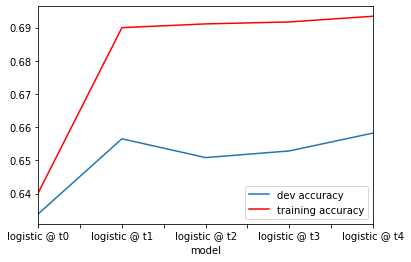

In [142]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Random Forest 

##### Random Forest @ $t_0$

In [143]:
# X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
# X_train, X_dev, alpha, coef, selection = lasso_reduction(X_train, X_dev)
# X_train.head()

In [144]:
len(y_train)

95232

In [145]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)


parameters_rf = {'n_estimators':[100,100],'max_features':[1,int(np.sqrt(len(dem_var)))],'max_depth':[10,10]}
rf = RandomForestClassifier(n_jobs=-1, random_state = random_state)

t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_depth': 10, 'max_features': 6, 'n_estimators': 100}

accuracy on the dev set is: 0.798879202988792

accuracy on the train set is: 0.866079512717096

confusion matrix:

[[1227  153]
 [ 170   56]]

classification report:

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1380
           1       0.27      0.25      0.26       226

    accuracy                           0.80      1606
   macro avg       0.57      0.57      0.57      1606
weighted avg       0.79      0.80      0.80      1606

the runtime is 0.16569579442342122 minutes


,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,random forest @ t0,42,24298,0.798879,0.86608


##### Random Forest @ $t_1$

In [146]:
# rf_var  = ['COHORT', 'EMPLID', 'TERM_CODE', 'SEMESTER_INDEX','MAJOR_CHANGE_INDICATOR', 'MAJOR_CHANGE_CNT', 'UNITS_TAKEN', 'BCMP',
#        'A', 'AU', 'B', 'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU',
#        'SUMMER', 'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA', 'CUM_GPA',
#        'BCMP_TERM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE',
#        'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'T_COMP', 'T_READ',
#        'T_MATH', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN',
#        'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
#        'TWO OR MORE RACES, INCLUDING MINORITY',
#        'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN',
#        'VISA NON U.S.', 'CONTINUING GENERATION STUDENT',
#        'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN', 'DEP_FAM_1',
#        'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
#        'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
#        'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
#        'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
#        'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
#        'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
#        'PELL_TRADITIONAL']

In [147]:
# X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)
# X_train, X_dev, alpha, coef, selection = lasso_reduction(X_train, X_dev)
# X_train.head()

In [148]:
X_train.columns

Index(['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN',
       'VISA NON U.S.', 'CONTINUING GENERATION STUDENT',
       'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN', 'DEP_FAM_1',
       'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25',
       'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
       'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL'],
      dtype='object')

In [149]:
X_train.shape

(24298, 42)

In [150]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

parameters_rf = {'n_estimators':[100,100],'max_features':[1,int(np.sqrt(len(var)))],'max_depth':[1,32]}

t1_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t1')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_depth': 32, 'max_features': 7, 'n_estimators': 100}

accuracy on the dev set is: 0.8444173276388042

accuracy on the train set is: 1.0

confusion matrix:

[[1363   45]
 [ 210   21]]

classification report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.91      1408
           1       0.32      0.09      0.14       231

    accuracy                           0.84      1639
   macro avg       0.59      0.53      0.53      1639
weighted avg       0.79      0.84      0.81      1639

the runtime is 0.17218346993128458 minutes


,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,random forest @ t0,42,24298,0.798879,0.86608
1,random forest @ t1,53,24726,0.844417,1.00000


##### Random Forest @ $t_2$

In [151]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

t2_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t2')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

/localhome/exx/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



the optimal parameters are: {'max_depth': 32, 'max_features': 7, 'n_estimators': 100}

accuracy on the dev set is: 0.8282556750298686

accuracy on the train set is: 1.0

confusion matrix:

[[2702  158]
 [ 417   71]]

classification report:

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2860
           1       0.31      0.15      0.20       488

    accuracy                           0.83      3348
   macro avg       0.59      0.55      0.55      3348
weighted avg       0.79      0.83      0.80      3348

the runtime is 0.4208170731862386 minutes


,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,random forest @ t0,42,24298,0.798879,0.86608
1,random forest @ t1,53,24726,0.844417,1.00000
2,random forest @ t2,53,50802,0.828256,1.00000


##### Random Forest @ $t_3$

In [152]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

t3_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t3')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

/localhome/exx/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



the optimal parameters are: {'max_depth': 32, 'max_features': 7, 'n_estimators': 100}

accuracy on the dev set is: 0.8183903252710593

accuracy on the train set is: 1.0

confusion matrix:

[[3783  292]
 [ 579  142]]

classification report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4075
           1       0.33      0.20      0.25       721

    accuracy                           0.82      4796
   macro avg       0.60      0.56      0.57      4796
weighted avg       0.79      0.82      0.80      4796

the runtime is 0.5834651430447896 minutes


,model,Number of Features,Number of Obs,dev accuracy,training accuracy
0,random forest @ t0,42,24298,0.798879,0.86608
1,random forest @ t1,53,24726,0.844417,1.00000
2,random forest @ t2,53,50802,0.828256,1.00000
3,random forest @ t3,53,72374,0.818390,1.00000


In [153]:
# ax = plt.gca()

# accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
# accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

# plt.show()

### Feature Importance from Random Forest

In [154]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=rf_var)


NameError: name 'rf_var' is not defined

### XGBoost

##### XGBoost @ $t_0$

In [ ]:
def run_model_xgb(label,num_round):
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_dev = xgb.DMatrix(X_dev, label=y_dev)
    
    param = {'max_depth': 6, 'eta': 0.6, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(d_dev, 'eval'), (d_train, 'train')]

    bst = xgb.train(param, d_train, num_round, evallist, verbose_eval=True)
    
    y_dev_pred = (bst.predict(d_dev) > 0.5) * 1
    y_train_pred = (bst.predict(d_train) > 0.5) * 1
    p_pred = bst.predict(d_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    dev_f1 = f1_score(y_dev,y_dev_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    dev_precision = precision_score(y_dev,y_dev_pred)
    train_precision = precision_score(y_train,y_train_pred)
    dev_recall = recall_score(y_dev,y_dev_pred)
    train_recall = recall_score(y_train,y_train_pred)
    dev_roc = roc_auc_score(y_dev,y_dev_pred)
    train_roc = roc_auc_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n {}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    metrics = {'model':label,
               'dev accuracy':[dev_accuracy], 
               'training accuracy':[train_accuracy],
               'dev f1':[dev_f1],
               'training f1':[train_f1],
               'dev precision':[dev_precision],
               'training precision':[train_precision],
               'dev recall':[dev_recall],
               'training recall':[train_recall],
               'dev roc':[dev_roc],
               'training roc':[train_roc]
              } 
    
    predict = {'predicted dev values':[y_dev_pred],
               'predicted training values':[y_train_pred],
               'predicted probabilities':[p_pred],
               'confusion matrix':[cm],
               'classification report':[report]}
    
    return (metrics, predict)

In [ ]:
epochs = 14

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
metrics,_ = run_model_xgb('xgb@t0',epochs)

In [ ]:
acc_mat = accuracy_matrix_fn(pd.DataFrame(), metrics)
acc_mat

##### XGBoost @ $t_1$

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

metrics,_ = run_model_xgb('xgb@t1',epochs)

In [ ]:
1-y_dev.mean()

In [ ]:
acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

##### XGBoost @ $t_2$

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t2',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

##### XGBoost @ $t_3$

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t3',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

##### XGBoost @ $t_4$

In [ ]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t4',epochs)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

In [ ]:
seq['TRAIN2'].keys()

In [ ]:
X_train